In [43]:
import params
import pickle
from astropy.table import Table
import make_dictionaries
import matplotlib as mpl

source_directory = params.source_directory
full_sample = params.full_sample
vl_sample = params.volume_limited_sample

In [44]:
f_inv = make_dictionaries.f_inv
% matplotlib inline

data = fits.getdata(source_directory + vl_sample,1)
data = Table(data)

questions = make_dictionaries.questions
question = 't01_smooth_or_features'

z_base = 0.03

In [45]:
with open('save_stuff/kparams.p', 'rb') as handle:
    kparams = pickle.load(handle)
    
with open('save_stuff/cparams.p', 'rb') as handle:
    cparams = pickle.load(handle)
    
with open('save_stuff/fit_setup.p', 'rb') as handle:
    fit_setup = pickle.load(handle)

In [46]:
def get_fit_setup(fit_setup, m):
    def get_m(x):
        return x[m] if m in x.keys() else x[None]
    func = get_m(fit_setup['func'])
    p0 = get_m(fit_setup['p0'])
    bounds = get_m(fit_setup['bounds'])
    return func, p0, bounds


def function_inversion(value,func,k,kb,c,cb):
    # for use when function has no mathematical inverse
    xg = np.log10(np.linspace(0.01,1,100))
    low_z_values = func(xg,kb,cb)
    high_z_value = func(value,k,c)
    i = (np.abs(low_z_values-high_z_value)).argmin()
    x = xg[i]
    return x


def make_axes(n_morph,xlabel='$\log(f_v)$',ylabel='cumulative fraction'):

    x_dimension = math.ceil(math.sqrt(n_morph))
    y_dimension = math.ceil(n_morph/x_dimension)
    n_plots = x_dimension*y_dimension
    n_spare = n_plots-n_morph
    remove_axes = np.arange(-n_spare,0)
    fig,axes = plt.subplots(y_dimension,x_dimension,sharex=True,sharey=True,figsize=(5*x_dimension,5*y_dimension))
    if n_morph >= 3:
        for ax in axes[-1,:]:
            ax.set_xlabel(xlabel)
        for ax in axes[:,0]:
            ax.set_ylabel(ylabel) 
    else:
        axes[0].set_xlabel(xlabel)
        axes[0].set_ylabel(ylabel)
        axes[1].set_xlabel(xlabel)
    plt.subplots_adjust(hspace=0,wspace=0)
    axes=axes.ravel()
    for m in remove_axes:
        fig.delaxes(axes[m])
    return fig,axes


def kcfunc(x, A0, AM, AR, Az):
    # linear combination of (magnitude, size, redshift) + an offset
    r = A0 + AM*x[0] + AR*x[1] + Az*x[2]    
    return r

In [52]:
def debias(data, z_base, kcfunc, kparams, cparams,
           question,questions):
    # Debias the dataset
    answers = questions[question]['answers']
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    
    debiased = data[morph_fv_cols]

    # Each galaxy gets a function fit to its M,R and z parameters, which are scaled
    # to the equivalent M and r functions at low z.

    for m, fv_col in enumerate(morph_fv_cols):
        fv = debiased[fv_col]
        fv_nonzero = fv > 0
        log10fv = np.log10(np.asarray(fv[fv_nonzero]))
        
        func, _, _ = get_fit_setup(fit_setup, m)
        i_func = fit_setup['inverse'][m]

        d = data[fv_nonzero]
        x = np.array([d['PETROMAG_MR'],
                      np.log10(d['PETROR50_R_KPC']),
                      d['REDSHIFT_1']], np.float64)
        k = kcfunc(x, *kparams[m])
        c = kcfunc(x, *cparams[m])

        # create version of x with all redshifts at z_base
        xb = x.copy()
        xb[-1] = z_base
        
        kb = kcfunc(xb, *kparams[m])
        cb = kcfunc(xb, *cparams[m])

        # possibly deal with any functions outside the k and c limits here

        if i_func == None:
            log10fv_debiased = np.array([function_inversion(log10fv[v],f_inv,k[v],kb[v],c[v],cb[v])
                                         for v in range(len(log10fv))])
        else:
            cumfrac = func(log10fv, k, c)
            log10fv_debiased = i_func(cumfrac, kb, cb)
        fv_debiased = 10**(log10fv_debiased)

        debiased[fv_col][fv_nonzero] = fv_debiased

    return debiased

In [48]:
debiased = debias(data,0.03,kcfunc,kparams,cparams,question,questions)

In [50]:
def plot_debiased(data, debiased,question,questions,subsample=10):
    # Plot debiased values vs. raw values for comparison. Blue -> red with z.
    answers = questions[question]['answers']
    answerlabels = questions[question]['answerlabels']
    
    data = data[::subsample]
    debiased = debiased[::subsample]
    
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]

    fig, axarr = make_axes(n_morph=len(morph_fv_cols),xlabel='$f_{v,raw}$',ylabel='$f_{v,debiased}$')

    z = data['REDSHIFT_1']

    for m, fv_col in enumerate(morph_fv_cols):
        ax = axarr.ravel()[m]
        sc = ax.scatter(data[fv_col], debiased[fv_col],
                        marker=".", c=z, edgecolor='',
                        cmap=plt.cm.coolwarm,
                        norm=mpl.colors.LogNorm())

        ax.axis((0, 1, 0, 1))
        ax.plot([0,1],[0,1],"k-")

        ax.text(0.4, 0.9, answerlabels[m], fontsize='small', ha='left')

        if m > 2:
            ax.set_xlabel(r"$f_v$")
        if m == 0 or m == 3:
            ax.set_ylabel(r"$f_{v,\mathrm{debiased}}$")

    fig.subplots_adjust(hspace=0, wspace=0, right=0.85)

    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    cbar = fig.colorbar(sc, cax=cbar_ax, format='%.2f')
    cbar_ax.set_yticks([0.04,0.06,0.08])
    cbar.ax.set_ylabel('redshift')
    
    fig.savefig('figures/' + question +'/debiased_plots/debiased.pdf',dpi=100)

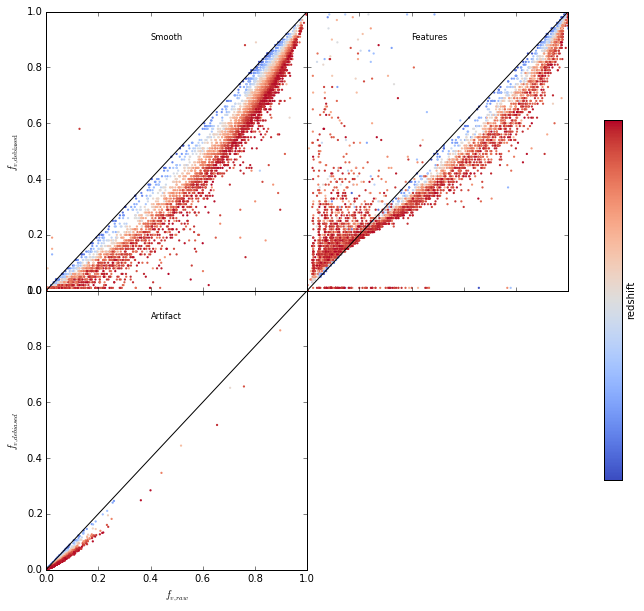

In [51]:
plot_debiased(data,debiased,question,questions)

In [82]:
z_v = np.argmax(data['REDSHIFT_1'])
z = data['REDSHIFT_1'][z_v]
Mr = data['PETROMAG_MR'][z_v]
R50 = data['PETROR50_R_KPC'][z_v]

x = [Mr,R50,z]
xb = [Mr,R50,0.03]

k = kcfunc(x, *kparams[1])
c = kcfunc(x, *cparams[1])

kb = kcfunc(xb, *kparams[1])
cb = kcfunc(xb, *cparams[1])

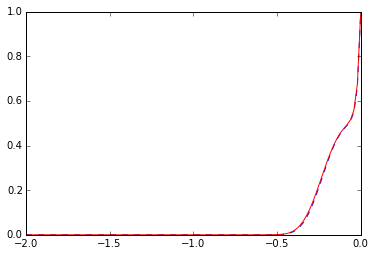

In [83]:
func, _, _ = get_fit_setup(fit_setup, 1)



(-1.5, 0)

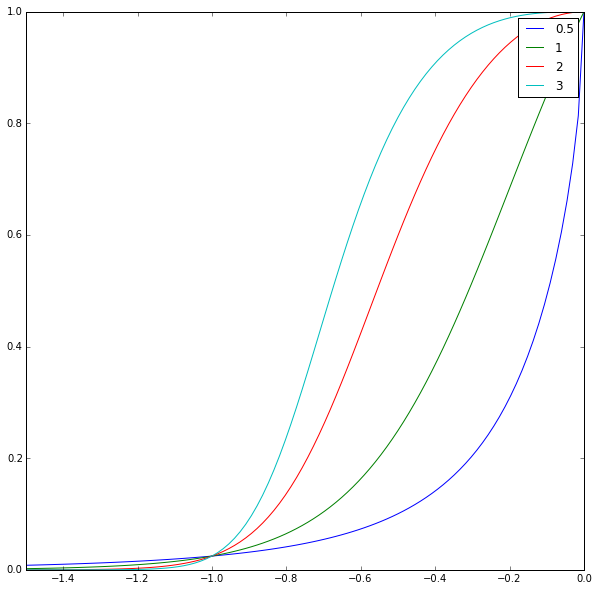

In [142]:
xg = np.linspace(-1.5,0,100)

def f_logistic(x, n):
    k = 5
    c = -1
    # Function to fit the data bin output from the raw plot function
    L = 1 + np.exp(c)
    r = L / (1.0 + np.exp(k * ((-x)**n) + c))
    return r

plt.figure(figsize=(10,10))
for n in [0.5,1,2,3]:
    plt.plot(xg,f_logistic(xg,n),label='{}'.format(n))
    plt.legend()

plt.ylim([0,1])
plt.xlim(-1.5,0)